<a href="https://colab.research.google.com/github/SawsanYusuf/The_Price_of_Netflix_Stocks/blob/main/Time_Series_Data_with_ARMA_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time-Series Data with ARMA Model




In this article, we aim to create an Autoregressive Moving Average (ARMA) model to predict the close price of NFLX stocks. Then, we will tune our model parameters to improve the performance. Before we begin, let's get to know the libraries we will use.

In [ ]:
!pip install --upgrade pandas
!pip install --upgrade pandas-datareader
!pip install statsmodels --upgrade

In [ ]:
#Import libraries 
import inspect
import time
import warnings
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import seaborn as sns
import pandas_datareader.data as web

from sklearn.metrics import mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

warnings.filterwarnings("ignore")

## 1.Prepare

### 1.1 Import Data

We need to make daily predictions. To use these data for this goal, we need to adjust the intervals at which we have our data. We should be careful that this process will cause missing values. To deal with this problem, we will use the forward-fill technique. And since we're going to use a single feature, it looks like instead of using the data frame, we're going to use a series. 

In [ ]:
#Get the stock quote
dataset = web.DataReader('NFLX', data_source='yahoo' )
#show the data
y = dataset["Close"]. resample("1D").mean().fillna(method="ffill")
y.head()

Date
2017-11-17    193.199997
2017-11-18    193.199997
2017-11-19    193.199997
2017-11-20    194.100006
2017-11-21    196.229996
Freq: D, Name: Close, dtype: float64

### 1.2 Explore

Now Let’s explore it. First, we need to check the data distribution to examine if we have any outliers. The best way to do this is the box plot or the histogram.

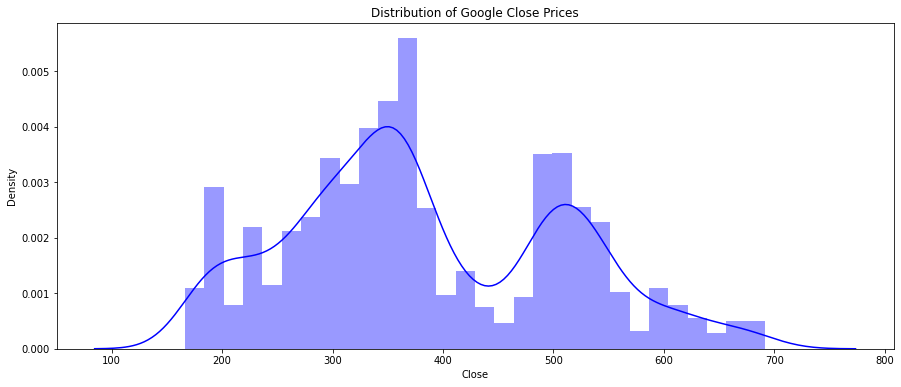

In [ ]:
fig, ax = plt.subplots(figsize=(15, 6))
sns.distplot(y, kde = True, color = 'blue', bins = 30, ax = ax)
ax.set_title("Distribution of Google Close Prices");

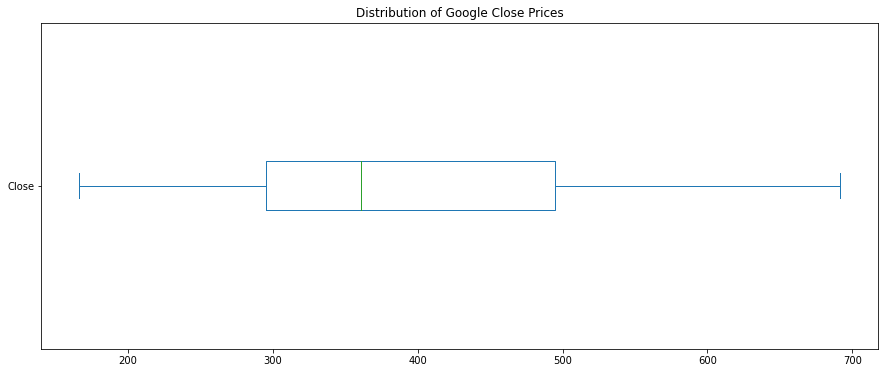

In [ ]:
fig, ax = plt.subplots(figsize=(15, 6))
y.plot(kind="box", vert=False, title="Distribution of Google Close Prices",ax=ax);

As shown in the two plots, there is no irregular distribution, and we don't have any outliers. Now, let's take a look at how our stock prices move over time, so let's create a time series plot.

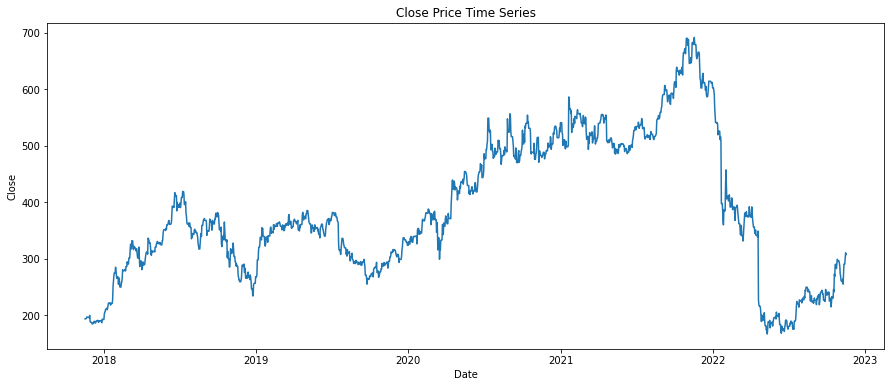

In [ ]:
fig, ax = plt.subplots(figsize=(15, 6))
sns.lineplot(x = y.index, y = y, data = y, ax=ax)
ax.set_title("Close Price Time Series");

Let’s look at the general trend for the close price. I will use the average rolling technique and set the window size to 30 (the number of days a month).

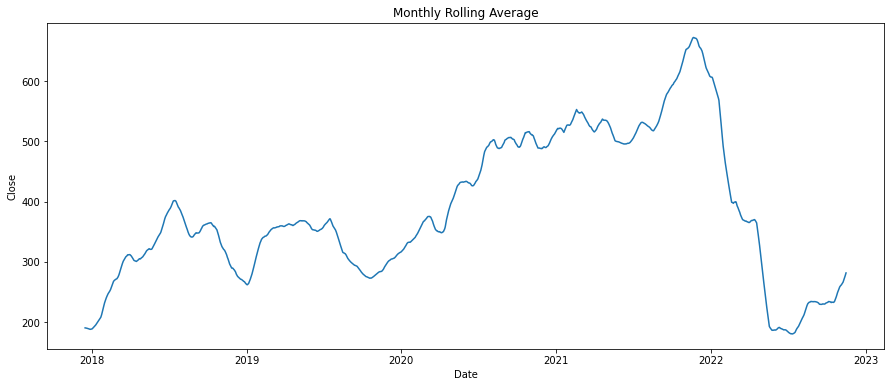

In [ ]:
fig, ax = plt.subplots(figsize=(15, 6))
sns.lineplot(x = y.index, y = y.rolling(30).mean(), data = y, ax=ax)
ax.set_title("Monthly Rolling Average");

Our model will use the previous values to make predictions for now and the future. For example, we can use what happened a day ago to predict what happens now. What happened a day ago informs what happens today, right? But is no reason to limit ourselves to a lag of one day. So the question we need to ask ourselves is how many lags we should have in our model. To find the answer, we need to use the ACF and PACF plots. Let's start with the ACF.

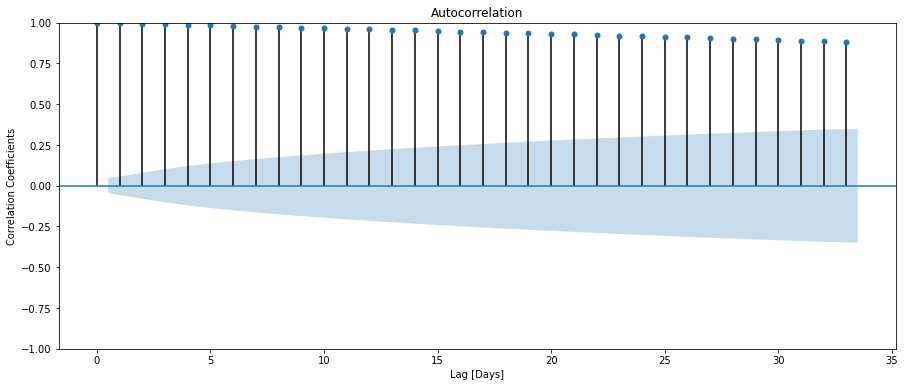

In [ ]:
fig, ax = plt.subplots(figsize= (15,6))
plot_acf(y, ax = ax)
plt.xlabel("Lag [Days]")
plt.ylabel("Correlation Coefficients");

A lot is going on in this plot. So let's unpack it piece by piece. First, let's look at the axes. So, look at that along the x-axis. We have the lag, and as we move from left to right, the lag gets bigger and bigger, and we're going further into the past, where we think that predictive power gets less than less. Then, along the y-axis, we have the correlation coefficient, Which goes from  -1 to 1, but if we have a strong correlation, it's one or negative. If we do not have it, it's zero. 

Another thing I want to point out is this kind of blue cloud. Anything inside this band has so small correlation coefficient, so it's not statistically significant. It's probably due to chance more than anything else.

If we have a lag of one, the correlation coefficient is around 0.0.997, and This predictive power goes down as the lags increase.

In [ ]:
y.corr(y.shift(1))

0.9971740759461906

You might assume we should use this plot to determine how many legs we want in our model. But actually, that's not the case. This ACF plot gives us a sense of how correlation changes as we change the lag. But, the way to determine how many lag terms we want in our model comes from the PACF plot. 

That's because our ACF plot is only half the story. Now, why do I say that? We know that there's a strong correlation between the stock price now and the stock price one day ago, right? We see that strong correlation, but there's no reason why we need to limit ourselves to now and one day ago. We can go anywhere on that timeline. I could go three days ago, and there's a strong correlation between what happened three days ago and four days ago. 

So that one-day correlation actually kind of echoes through or down through the different lags. So, what we want to do is we want to remove that echo and see which lags have strong predictive power and which are more just kind of holding that echo that spills over from the correlation that we saw at lag one.

Remember, when we looked at the correlation between y and y shift one, we saw 0.997, right? So, we have that correlation between now and one day in the past. If we look at the correlation between that and the y shift two days in the past, we have a like correlation. So what I want to do is remove the echoes. And that's what a partial autocorrelation function (PACF) plot does.


In [ ]:
print(y.corr(y.shift(1)))
print(y.shift(1).corr(y.shift(2)))

0.9971740759461906
0.9971736556656821


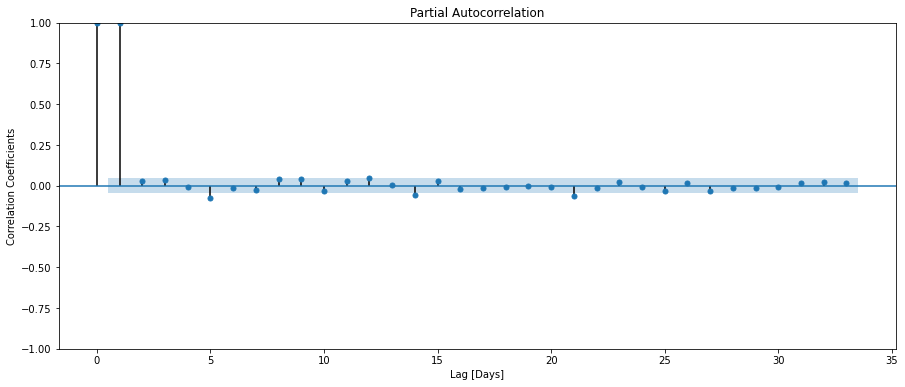

In [ ]:
fig, ax = plt.subplots(figsize=(15,6))
plot_pacf(y, ax=ax)
plt.xlabel("Lag [Days]")
plt.ylabel("Correlation Coefficients");

And here is our plot. Now, there's a lot about this PACF plot. That's similar to our ACF. For example, the x-axis is still lag, and then along the y-axis, we still have the correlation coefficient. Those are all the similarities, But you'll notice that after that everything is very different. The strength, the predictive power, and the correlation here are much smaller. 

Once you kind of pull out that lag one echo. So we can still see a little bit of predictive power at diffrernt lags. At 5, 14, a little bit at lags 21. here at 21, we have a negative one. 

Generally speaking, this plot tells us that beyond 21, and for the lags in between, you don't get a lot of predictive power for everything. It's just kind of an old chance. So, if we're going to create a good model, we don't want anything beyond a lag of 21. So we're done with our exploration. Let's begin building. 

### 1.3 Split

Time to split our data into train-test sets. I will choose small sets because the model needs high computational power. Let's create a training set **y_train** that contains only the prices from 2018 and 2019. And a test set **y_test** that contains the prices from 2020.

In [ ]:
y_train = y.loc["2018-01-01":"2019-12-31"]
y_test = y.loc["2020-01-01":]

##2. Build Model

### 2.1 Baseline

Let's Calculate the baseline mean absolute error for your model.

In [ ]:
y_train_mean= y_train.mean()
y_pred_baseline = [y_train_mean] * len(y_train)
mae_baseline= mean_absolute_error(y_train, y_pred_baseline)
print("Mean Close price:", round(y_train_mean, 2))
print("Baseline MAE:", round(mae_baseline, 2))

Mean Close price: 323.53
Baseline MAE: 35.81


### 2.2 Iterate

In this phase, I want to set a range of possible values for p and q, the two hyperparameters for our ARMA model. But what is P? What is Q? What are hyperparameters? What is an ARMA model? Before we do any of the coding stuff, we need to talk a little bit about these concepts.

Let's start with the AR part, this is it's equation, the simplest version of the AR model where we try to predict the presence, here as Yt, in terms of what happened a one-time step in the past, one day for us for this particular problem. So that's what this equation is. And remember, we're not just limited to looking one step in the past. When we do an AR model we can do, we can do as many time steps in the past as we can.

```
 Y_T= β_°+ β_1 Y_(T-1)  
 
```



Here, β_° is a white noise or residual error with zero mean. And the number of steps we go into the past, the number of terms we kind of add to this equation. We call that lag, and for shorthand in math talk, we usually call it p. So, that's our AR model. So, looking at past readings to make a present prediction.

Now we have the AR part. Let's add the MA part. And the way that the MA part works is that we don't need to look at just past readings. We can also look at our past predictions and the error in them. So, we have to add another term to our equation. In addition to looking at the previous reading, we will also look at the difference between our past prediction and the actual value. So the error is the difference between these two at a previous time step.


```
 Y_T= β_°+ β_1 Y_(T-1) + θ_(T-1)  
 
```



Now the question that I want to answer is, why would we want to have this MA term? Why would we want to add a moving average to our term? The reason is that time series models can often suffer when there is something called exogenous shocks, which means kind of one-time events that throw the readings several times, subsequent time, steps out of the norm.

For example, if you live in the USA and were trying to predict the air quality in Los Angeles on July 5th, you would need to know that July 4th is independence day in the United States. Everyone is shooting off fireworks. And so, on July 5th, there is a lot of pollution in the air, and for every subsequent rating after that, there's going to be pollution around for the next day or two.

Likewise, Someone might demolish a building and might throw a lot of particular matter into the air, and these kinds of a one-time event. 

A kind of shock event that can have echoes in subsequent predictions, and we can anticipate those by turning by using this sort of error term, which will be helpful for a model.

A couple of other important notes, We call the number of time steps we look back for our AR model as lag and P for shorthand. For our MA term, we use the error lag, and the letter we use to abbreviate that is Q. So, in the ARMA model, we want to decide what P and Q are. P and Q are examples of what we're going to call hyperparameters.

Now, why do we call these hyperparameters? Before we fit our model with data, we decide how many lag and error lag terms we will have in our equation. That will affect the way that the model is going to train. That's called a hyperparameter.

Now, if you're a real-time series, we would use the PACF plot to determine what the best lag would be, the best value for P. And you would use the ACF plot to determine the best value for Q. But there's another way to choose the best for P and Q. That is doing something called hyperparameter tuning. So, for the possible values for P, we're going to create a range from 0 to 25 by step of 8. Next, we have the parameters for Q, and here we will do a smaller range from 0 to 3 by step of 1.

In [ ]:
p_params = range(0,25,8)
q_params = range(0,3,1)

And if you're asking yourself, why are we doing more p prams than q params, the reason is **that's kind of how ARMA models work when we're thinking of AR, or you're looking into the past, and we often look for into the past to predict the present or the future. But that's so we have a lot of p parameters. But for Q, these are kind of quick short-term shocks to the system. And so you don't often have large numbers for Q. We keep it small, one, two, three, something like that. Now that we have the possible hyperparameters we might use, we need to test them.

The next question is, how will we search across these different combinations of hyperparameters and define what gives us the best performance for our model? The answer is doing a grid search.

So, what we're going to need to do for each combination of P and Q is first, we're going to need to train a model with those hyperparameters. And then, we will need to calculate the training mean absolute error for that particular model. And then we're going to need to save that result. We will do that for every single combination in this grid. And once we have done, we're going to look at all of the different MAE values, and we're going to find the one that has the best performance.

In [ ]:
# Create dictionary to store MAEs
mae_grid = dict()
# Outer loop: Iterate through possible values for `p`
for p in p_params:
      # Create key-value pair in dict. Key is `p`, value is empty list.
      mae_grid[p] = list()
      # Inner loop: Iterate through possible values for `q`
      for q in q_params:
           # Combination of hyperparameters for model
           order = (p, 0, q)
           # Note start time
           start_time = time.time()
           # Train model
           model = ARIMA(y_train, order=order).fit()
           # Calculate model training time
           elapsed_time = round(time.time() - start_time, 2)
           print(f"Trained ARIMA {order} in {elapsed_time} seconds.")
           # Generate in-sample (training) predictions
           y_pred = model.predict()
           # Calculate training MAE
           mae = mean_absolute_error(y_train, y_pred)
           # Append MAE to list in dictionary
           mae_grid[p].append(mae)

     
print()
print(mae_grid)

Trained ARIMA (0, 0, 0) in 0.15 seconds.
Trained ARIMA (0, 0, 1) in 0.19 seconds.
Trained ARIMA (0, 0, 2) in 0.56 seconds.
Trained ARIMA (8, 0, 0) in 0.86 seconds.
Trained ARIMA (8, 0, 1) in 1.39 seconds.
Trained ARIMA (8, 0, 2) in 2.63 seconds.
Trained ARIMA (16, 0, 0) in 4.05 seconds.
Trained ARIMA (16, 0, 1) in 6.74 seconds.
Trained ARIMA (16, 0, 2) in 4.84 seconds.
Trained ARIMA (24, 0, 0) in 7.27 seconds.
Trained ARIMA (24, 0, 1) in 6.15 seconds.
Trained ARIMA (24, 0, 2) in 16.94 seconds.

{0: [35.808319337681304, 19.601878486252875, 13.081905245073592], 8: [4.524993039597883, 4.532420932752758, 4.5280494629139065], 16: [4.537309798559595, 4.567013451885762, 4.536807717976972], 24: [4.572782615669763, 4.570924590334879, 4.571978691449186]}


Now we could finally do analysis and see what set of hyperparameters gives us the best model performance. So now, let's take that dictionary and put it into a DataFrame.


In [ ]:
mae_df = pd.DataFrame(mae_grid)
mae_df.round(4)

,0,8,16,24
0,35.8083,4.5250,4.5373,4.5728
1,19.6019,4.5324,4.5670,4.5709
2,13.0819,4.5280,4.5368,4.5720


So we have all possible values for P, and then down the index, we have all possible values for Q. Then, in the middle, we have the different mean absolute errors for models trained with those sets of hyperparameters. It seems like some models perform better than others, but you know there is another way to see the numbers more clearly, creating a visualization. Let us turn this data frame into a heatmap.

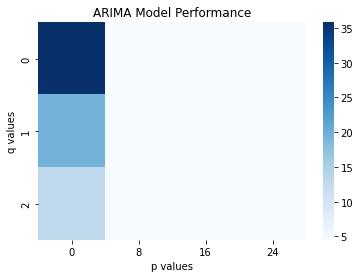

In [ ]:
sns.heatmap(mae_df, cmap = "Blues")
plt.xlabel("p values")
plt.ylabel("q values")
plt.title("ARIMA Model Performance");

First, all the models where P was 0 do not perform well. So that's the first big takeaway, and then the second big takeaway here is that once the p-value increased, the model performance not changed.

Honestly, the best one is the model where P was 8 and Q was 0. If we go back and look at MAE DataFrame, we can see that our best model with a mean absolute error of 4.5250, then our next best model with 4.5324, has almost little difference. We can get pretty good performance with other hyperparameters settings.

Now there's one last thing we need to do before evaluating our model. We need to look at all of those residuals. 

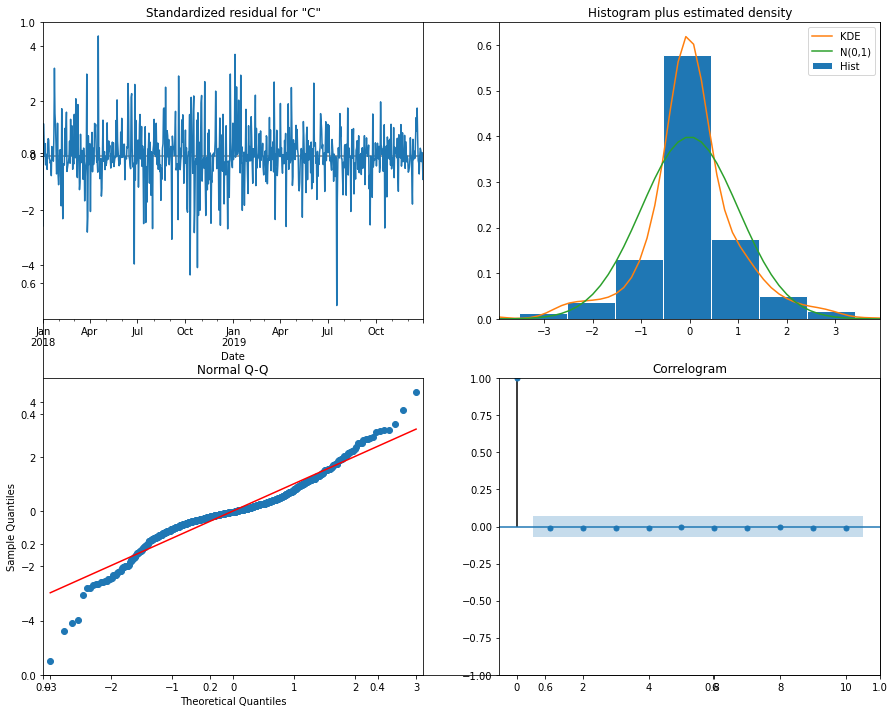

In [ ]:
fig, ax = plt.subplots(figsize=(15, 12))
model.plot_diagnostics(fig=fig);

So, we can see that we have four plots here. The first plot is the residuals for our model. these residuals look pretty good. They centered around zero, we do have events, but they centered around zero. 

We have a histogram of the residuals. Here, we want the histogram bars to follow the green normal distribution plot, and it looks like they have more or less due. In Normal Q-Q plot, all the dots should fall perfectly in line with the red line. Any significant deviations would imply the distribution is skewed.

The last one we want to show is the correlogram plot, the ACF plot of the residuals. It's as we want. Like where we have a zero lag, it's up at one for the correlation coefficient, and then everything goes down below just inside the blue bar. 

One thing you might notice here, the formatting, especially the axes, is not well labeled. There is kind of some overlaps and different stuff here. This is why I don't love this plot, but this is a good way to get a quick sense of whether our model is performing well. Now let's move on to the evaluation phase.

### 2.3 Evaluate

All right, time to evaluate our model. Let's do some walk-forward validation. I will choose the combination (8,0,0) for P and Q , which gives us the best performance.

In [ ]:
y_pred_wfv = pd.Series()
history = y_train.copy()
for i in range(len(y_test)):
    model = ARIMA(history, order=(8,0,0)).fit()
    next_pred = model.forecast()
    y_pred_wfv = y_pred_wfv.append(next_pred)
    history = history.append(y_test[next_pred.index])

In [ ]:
test_mae = mean_absolute_error(y_test, y_pred_wfv)
print("Test MAE (walk forward validation):", round(test_mae, 2))

Test MAE (walk forward validation): 6.2


We can see our walk-forward validation score. Here is 6.2, excellent for beating the baseline.

##3. Results

Time for the last task. So let's take our predictions from walk-forward validation, put them in a data frame, and then plot it out using plotly express.

In [ ]:
df_predictions = pd.DataFrame({"y_test": y_test,"y_pred_wfv": y_pred_wfv})
df_predictions.head()

,y_test,y_pred_wfv
2020-01-01,323.570007,323.473886
2020-01-02,329.809998,323.298419
2020-01-03,325.899994,329.405801
2020-01-04,325.899994,325.453980
2020-01-05,325.899994,326.364559


In [ ]:
fig = px.line(df_predictions, labels = {"value": " Close Price"}, title='ARMA Model: Actual Prices vs. Predicted Prices')
fig.show()

As we can see here, our model is designated in red compared to the actual labels in blue. And if we look at the general trend here, it's pretty good. 
